<IPython.core.display.Javascript object>


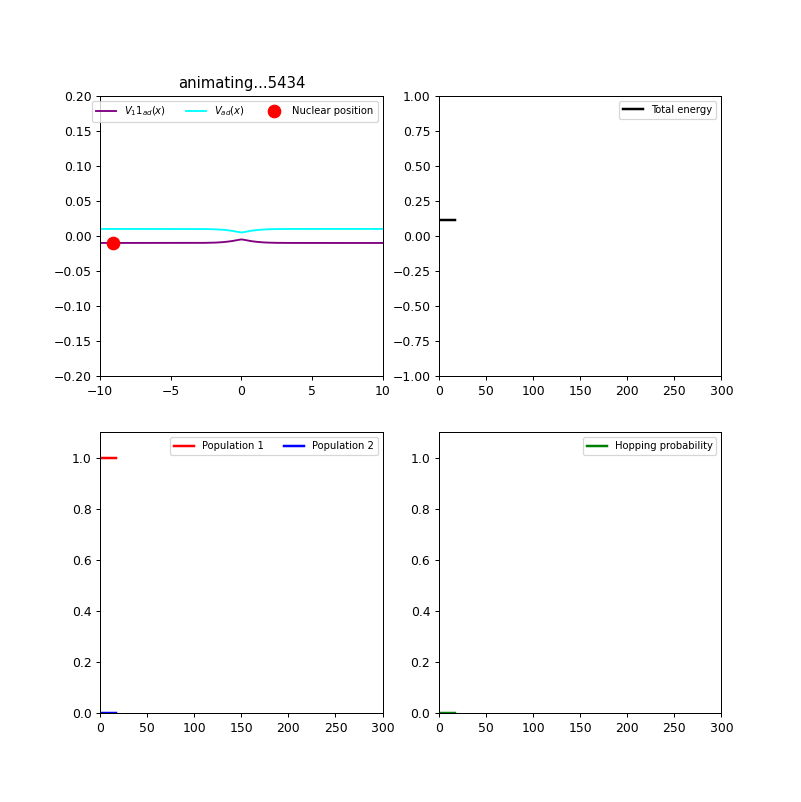

Button(description='Play', style=ButtonStyle())

In [10]:
# FSSH notebook
# The user is allowed to select from 3 potential energy surfaces (Tully models 1,2,3)
# Set up plot which illustrates the two potential energy surfaces
# Indicate which state we are on with a point
# Propagate the density matrix using ODE integrator
# Initial state is ground state

import numpy as np
from math import pi
from ipywidgets import Button, FloatSlider, HBox, VBox, IntProgress,Output
from ipywidgets import Dropdown, Layout, Accordion, Label
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import animation
from datetime import datetime
import math
import scipy.integrate

pause = False
%matplotlib notebook
######################################################################
# Set up plot

######################################################################
# Create the animation

# specify time steps and duration

style = {'description_width': 'initial'}

   
pot_select = Dropdown(
    options=['1. Tully 1', '2. Tully 2'],
    index = 0,
    description='Potential type:',
    disabled=False,
    style = style
)

output = Output(layout=Layout(width="400px"))

class tully1:
    def __init__(self, A = 0.01, B = 1.6, C = 0.005, D = 1.0):
        self.A = A
        self.B = B
        self.C = C
        self.D = D

    def V(self,x):
        if x > 0:
            v11 = self.A* ( 1.0 - np.exp(-self.B *x) )
        else:
            v11 = -self.A* ( 1.0 - np.exp(self.B *x) )
        v22 = -v11
        v12 = self.C * np.exp(-self.D*x**2)
        V_ = np.array([[v11, v12], [v12, v22]])
        return V_

    def dV(self, x):
        v11 = self.A * self.B * np.exp(-self.B * abs(x))
        v22 = -v11
        v12 = -2.0 * self.C * self.D * x * np.exp(-self.D *x**2)
        dV_ = np.array([[v11, v12], [v12, v22]])
        return dV_

   
    
def diag_Vmat(V):
    # consider making use of ref state to maintain consistent sign
#     print(V)
    energies, elec_coeffs = np.linalg.eigh(V)
    return energies,elec_coeffs


def kinetic_energy(vel, mass):
    return 0.5 * mass * vel*vel

# def total_energy(elec_state):
#     potential = elec_state.compute_potential(state)
#     kinetic = self.kinetic_energy()
#     return potential + kinetic

def calc_kinetic_energy(vel,mass):
    return 0.5 * mass *vel**2

## Rescales velocity in the specified direction and amount
# @param direction array specifying the direction of the velocity to rescale
# @param reduction scalar specifying how much kinetic energy should be damped
def rescale_ke(vel, mass, reduction):
    # normalize

    a = mass**2
    b = 2.0 *mass**2 * vel
    c = -2.0 * mass * reduction
    roots = np.roots([a, b, c])
    scal = min(roots, key=lambda x: abs(x))
    vel += scal 
    
def hop(current_state, elec_coeffs, elec_energies,vel, ndim,mass,dV):
    # revise this if you want to generalize to > 2 states
        global rho,P
        proposed_state = 1-current_state
        dij = compute_couplings(proposed_state, current_state, dV,elec_coeffs, elec_energies,ndim)        

        bij = -2.0 * np.real(rho[current_state, proposed_state]) *vel* dij

        #print("np.real(rho[current_state, proposed_state]) = {}".format(np.real(rho[current_state, proposed_state])))
        # probability of hopping from current state
        if bij >0:
            P = dt * bij / np.real(rho[current_state, current_state])
        else:
            P=0.
        zeta = np.random.uniform()
        if zeta < P:
            with output:
                print("hopping!")
            #  this will only work for a two-state model
            new_potential, old_potential = elec_energies[proposed_state], elec_energies[current_state]
            delta_V = new_potential - old_potential
            ke_comp = calc_kinetic_energy(vel, mass)
            if delta_V <= ke_comp:
                current_state = proposed_state
                rescale_ke(vel,mass,-delta_V)
        return current_state, P
    
def getHFforce(elec_coeffs,current_state,ndim,dV):
#     force=np.zeros(ndim)
    psi=elec_coeffs[current_state]
#     for d in range(ndim):
#     force = - (np.outer(psi, dV[:,:]@psi))[current_state,current_state]
    force = - (np.dot(psi, np.dot(dV,psi)))
#     with output:
#         print("force = {}".format(force))
    return force


def elec_prop(rho,vel,elec_coeffs,elec_energies, num_states,ndim):
    
        d = compute_nac(vel,elec_coeffs,elec_energies, num_states,ndim)
        prop_mat = np.zeros([2,2], dtype=np.complex64)
        prop_mat[0,0] = elec_energies[0]
        prop_mat[1,1] = elec_energies[1]
        prop_mat -= 1j * d
#        prop_mat *= -1j
        
        diags, coeff = np.linalg.eigh(prop_mat)
        cmat = np.matrix(elec_coeffs)
        cmat_T = cmat.getH()
        cconj = np.array(cmat_T)
        tmp_rho = np.dot(cconj, np.dot(rho, elec_coeffs))
        
        for i in range(2):
            for j in range(2):
                tmp_rho[i,j] *= np.exp(-1j * (diags[i] - diags[j]) * dt)
                rho[:] = np.dot(elec_coeffs, np.dot(tmp_rho, cconj))


        
        # def drho(time, y):
        #     ymat = np.reshape(y, [2, 2])
        #     d_rho = np.dot(prop_mat, ymat) - np.dot(ymat, prop_mat)
        #     return np.reshape(d_rho, [4])

        # rhovec = np.reshape(rho, [4])
        # integrator = scipy.integrate.complex_ode(drho).set_integrator('vode', method='bdf', with_jacobian=False)
        # integrator.set_initial_value(rhovec, time)
        # integrator.integrate(time + dt)
        # rho = np.reshape(integrator.y, [2,2])
        #print("rho = {}".format(rho))
        return rho

        
def compute_couplings(i,j,dV,elec_coeffs, elec_energies,ndim):
    dmat = np.zeros(ndim)
    if (i != j):
        
#        temp = dV@elec_coeffs[:,j]
#        print("temp = {}".format(temp))
#        dij = np.dot(elec_coeffs[:,i], dV@elec_coeffs[:,j])
        dij = np.dot(elec_coeffs[:,i].T, np.dot(dV[:,:], elec_coeffs[:,j]))
        #                dij = np.outer(elec_coeffs, dV@elec_coeffs)[i][j]
        dE = elec_energies[j] - elec_energies[i]
        print(dE)
        if abs(dE) < 1.0e-14:
            if dE < 0:
                dE = -1.0e-14
            else:
                dE = 1.0e-14
        dmat = dij / dE
        print(dmat)
    return dmat        
        ## returns \f$ \sum_\alpha v^\alpha D^\alpha \f$ where \f$ D^\alpha_{ij} = d^\alpha_{ij} \f$
def compute_nac(vel,elec_coeffs,elec_energies, num_states,ndim):
        nac_mat = np.zeros([ num_states,  num_states], dtype=np.complex64)
        for i in range( num_states):
            for j in range(i):
                dij = compute_couplings(i,j,dV,elec_coeffs, elec_energies,ndim)
                #print("vel = {}".format(vel))
                nac_mat[i, j] = vel*dij
                nac_mat[j, i] = - nac_mat[i, j]
        return nac_mat



def run_single_step():
  
    global rho, elec_energies, elec_coeffs,current_state, pe_model, mass, ndim, num_states, nuc_pos, vel

#     with output:
#         print("running single step of fssh")
    
   

   # for step in range(N_steps):
    print("nuc_pos = {}".format(nuc_pos))
    nuc_pos += vel*dt

    V = pe_model.V(nuc_pos)
    dV = pe_model.dV(nuc_pos)
    elec_energies, elec_coeffs = diag_Vmat(V)
    print("elec_energies = {}".format(elec_energies))
#     with output:
#         print("diagonalizing: energies = {}".format(elec_energies))
    F = getHFforce(elec_coeffs,current_state,ndim,dV)
    accel = F/mass
    vel += accel*dt
    rho=elec_prop(rho,vel,elec_coeffs,elec_energies, num_states,ndim)
    print("rho = {}".format(rho))

    actv_state,P=hop(current_state, elec_coeffs, elec_energies,vel, ndim,mass,dV)
    current_state=actv_state
    return actv_state, elec_energies,P    


def init():
#     psi1_x_line.set_data([], [])
    V1_ad_x_line.set_data([],[])
    V2_ad_x_line.set_data([],[])
    tot_e_line.set_data([],[])
    pop1_line.set_data([],[])
    pop2_line.set_data([],[])
    prob_line.set_data([],[])


   
    title.set_text("Title")
    
    return V1_ad_x_line,V2_ad_x_line,pop1_line,pop2_line,prob_line



pe_model = tully1()


fig = plt.figure(figsize=(10,10))
fig.canvas.header_visible = True
# plotting limits
xlim = (-10, 10)
# tlim = (0,S.tot_steps)
Nx = 1000
N_steps = 300


x = np.linspace(-10,10,Nx)
pes = np.zeros((Nx,2))

for i,pos in enumerate(x):
    
    V = pe_model.V(pos)
#     print(V)
    energy_arr, coeffs = diag_Vmat(V)
    pes[i,:] = np.array(energy_arr)


# ymin = 0.
# if pot_select.index == 0:
#     ymax = 1.0 
#     ylims=(ymin - 0.2 * (ymax - ymin),
#                             ymax + 0.2 * (ymax - ymin))
# else:
xlim=(-10,10)
ylims=(-0.2,0.2)
    
Elims=(-1,1)
poplims=(0,1.1) 
tlims=(0,N_steps)
ax1 = fig.add_subplot(221, xlim=xlim,
                      ylim=ylims)
ax2 = fig.add_subplot(222, xlim=tlims,
                      ylim=Elims)

# subplot for populations
ax3 = fig.add_subplot(223, xlim=tlims,
                      ylim=poplims)

ax4 = fig.add_subplot(224, xlim=tlims, ylim=poplims)
# psi1_x_line, = ax1.plot([], [], c='r', label=r'$|c_1(x)|$', linewidth=1.2)

V1_ad_x_line, = ax1.plot([], [], c='purple', label=r'$V_11_{ad}(x)$')
V2_ad_x_line, = ax1.plot([], [], c='cyan', label=r'$V_{ad}(x)$')#
V1_ad_x_line.set_data(x,pes[:,0])
V2_ad_x_line.set_data(x,pes[:,1])       
pos_marker, = ax1.plot([], [], 'ro', ms=10, label='Nuclear position')
      
tot_e_line, = ax2.plot([], [], c='black', label=r'Total energy', linewidth=2.0)
pop1_line, = ax3.plot([], [], c='red', label=r'Population 1', linewidth=2.0)
pop2_line, = ax3.plot([], [], c='blue', label=r'Population 2', linewidth=2.0)
prob_line, = ax4.plot([], [], c='green', label=r'Hopping probability', linewidth=2.0)

# pop1_line.set_data(0,np.real(rho[0,0]))

# pop2_line.set_data(0,np.real(rho[1,1]))

# V1_di_x_line, = ax1.plot([], [], c='green', label=r'$V_{di}(x)$')
# V2_di_x_line, = ax1.plot([], [], c='green')#, label=r'$V_{di}(x)$')

# psi1_x_line.set_visible(True)

title = ax1.set_title("")
ax1.legend(prop=dict(size=8), ncol=4, loc=1)
ax2.legend(prop=dict(size=8), ncol=4, loc=1)
ax3.legend(prop=dict(size=8), ncol=4, loc=1)
ax4.legend(prop=dict(size=8), ncol=4, loc=1)

           


def animate(i):
    global title,output,idx,nuc_pos,step,rho,vel,mass,accel,F,V,dV,elec_energies,current_state,elec_coeffs,actv_state 
    global tot_e_list,pop1_list, pop2_list,prob_list#, pop1_line, pop2_line
    # can just set pause = True after each step in the algo
   

    Nx = 1000
    x = np.linspace(-10,10,Nx)
    animation_dur = 50
    
    if step<N_steps:
        actv_state, elec_energies,P =run_single_step()
        ke=calc_kinetic_energy(vel,mass)
        total_energy = elec_energies[actv_state] + ke
        tot_e_list.append(total_energy)
        pop1_list.append(np.real(rho[0,0]))
#         with output:
#             print("pop1_list = {}".format(pop1_list))
        pop2_list.append(np.real(rho[1,1]))
        prob_list.append(P)
        step+=1
    else:
        step=0
        tot_e_list = []
        pop1_list = []
        pop2_list = []
        prob_list=[]
        nuc_pos=-10.0
        rho[0,0] = 1.0
        rho[0,1]=0.
        rho[1,0] = 0.
        rho[1,1] = 0.
        current_state = 0
        elec_energies = np.zeros(2)
        elec_coeffs = np.array([1,0])
        time=0.
        ndim=1
        num_states=2
        # specify constants
        mass = 2000.      # particle mass
        F = 0.
        momentum = 22.0
        vel = momentum/mass

        V = pe_model.V(nuc_pos)
        dV = pe_model.dV(nuc_pos)
        elec_energies, elec_coeffs = diag_Vmat(V)
        # Propagation for individual trajectory
    
        F = getHFforce(elec_coeffs,current_state,ndim,dV)
        accel = F/mass
        vel += 0.5*dt*accel        
    
        
#     V1_ad_x_line.set_data(x,pe_model.V(x)[0])
#     V2_ad_x_line.set_data(x,pe_model.V(x)[1])
      
#     update()
   
    
    V1_ad_x_line.set_data(x,pes[:,0])
    V2_ad_x_line.set_data(x,pes[:,1]) 
    tot_e_line.set_data(np.arange(step),tot_e_list)
    pop1_line.set_data(np.arange(step),pop1_list)
    pop2_line.set_data(np.arange(step),pop2_list)
    prob_line.set_data(np.arange(step),prob_list)
    
    with output:
        print("actv_state = {}".format(actv_state))
    pos_marker.set_data(nuc_pos,elec_energies[actv_state]) # draw marker on active surface

#     pos_marker.set_data(nuc_pos,elec_energies[actv_state]) # draw marker on active surface
#     pos_marker.set_data(0,0)


    title.set_text("animating...{}".format(i))

    return  V1_ad_x_line,  V2_ad_x_line, pos_marker, pop1_line, pop2_line, prob_line, title

time=0.
step=0
ndim=1
num_states=2
# specify constants
hbar = 1.0   # planck's constant
mass = 2000.      # particle mass
F = 0.
momentum = 22.0
vel = momentum/mass
dt=0.05/vel

P=0. # hopping probability

N_steps = 300
N_trajs=200
t_max = 120


V = np.zeros((2,2))
dV = np.zeros((2,2))
elec_energies = np.zeros(2)
elec_coeffs = np.array([1,0])

tot_e_list = []
pop1_list = []
pop2_list = []
prob_list = []

rho = np.zeros([2,2], dtype = np.complex64)
rho[0,0] = 1.0
current_state = 0

nuc_pos=-10.0

V = pe_model.V(nuc_pos)
dV = pe_model.dV(nuc_pos)
elec_energies, elec_coeffs = diag_Vmat(V)

# Propagation for individual trajectory

F = getHFforce(elec_coeffs,current_state,ndim,dV)
accel = F/mass
vel += 0.5*dt*accel  

anim = animation.FuncAnimation(fig, animate,frames=N_steps*N_trajs, interval=0.1, blit=False,repeat=True)
#fig.show()
with output:
        print(anim)
    
def onClick(event):
    global pause
    pause ^= True
    with output:
        print("onClick")
    
    if button_pause.description == "Pause":
        button_pause.description = "Play"
        print("pausing")

        anim.event_source.stop()
    else:
        button_pause.description = "Pause"
        with output:
            print("playing")
        anim.event_source.start()
       


button_pause = Button(description="Play");
button_pause.on_click(onClick)
display(button_pause);
           

In [11]:
display(output)


Output(layout=Layout(width='400px'))